In [1]:
import os, sys
from os.path import abspath, dirname
import zarr
import z5py
import numpy as np
import pandas as pd
from glob import glob 
from skimage.measure import regionprops
from skimage.io import imread, imsave
from scipy import stats
from scipy.stats import skewnorm, lognorm
from scipy.optimize import minimize
import itertools
import collections

sys.path.append('../../')
from easi_fish import n5_metadata_utils as n5mu
from easi_fish import roi_prop, spot, intensity
import warnings
warnings.filterwarnings('ignore')

import importlib
importlib.reload(spot)
importlib.reload(roi_prop)
importlib.reload(intensity)

<module 'easi_fish.intensity' from '/u/project/zipursky/f7xiesnm/code/easifish-proc/bydatasets/sparse06/../../easi_fish/intensity.py'>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

sns.set_style('white', rc={'axes.grid':True})
sns.set_context('talk')

Spot counts for cells with highly expressed genes (dense spots)
1. Measure total intensity of every ROI after bleed-through correction and background subtraction.
2. Calculate the number of spot from total intensity based on unit-spot intensity
3. Correlate the number of spots (from air-localize) with the total fluorescence intensity/voxel in each ROI and determine a 'cutoff'. 
   Spot count > cutoff: use spot count converted based on total fluorescence intensity; 
   Spot count < cutoff: use spot count from Airlocalize

### On units
- all images are based on pixel units - 
- roi meta file (output) are based on physical unit (um - pre-expansion)
- spots files are in um (post-expansion)

In [4]:
ddir = '/u/home/f/f7xiesnm/project-zipursky/easifish/sparse06'
output_dir = ddir + '/proc/r1_flatfield'
!mkdir -p $output_dir
!ls $output_dir

In [5]:
## input


fix_round = 'r1_flatfield'
mov_rounds = [] 
round_channels = collections.OrderedDict({
    'r1': ('c0', 'c2', 'c4'),
})

dapi_channel = 'c3'
lb_scale = 's3'
lb_res = [1.84,1.84,1.68]
ex = 2

# images
fix_dir  =  ddir + f"/outputs/{fix_round}/stitching/export.n5"
lb_dir  =   ddir + f"/outputs/{fix_round}/segmentation/{fix_round}-{dapi_channel}.tif"
reg_dirs = []
subpath =   f'/{dapi_channel}/{lb_scale}' 


# spot dir for every gene
fx_spots = [
    ddir + f'/outputs/r1_flatfield/v3/spots/spots_c00.txt',
    ddir + f'/outputs/r1_flatfield/v3/spots/spots_c0.txt',
]


intn_threshs = [
    150, 
    150, 
    150, 
]
    
for f in fx_spots:
    assert os.path.isfile(f)

## output
out_badroi = os.path.join(output_dir, 'bad_roi_list.npy')
out_allroi = os.path.join(output_dir, "roi_all.csv") 
out_roi = os.path.join(output_dir, "roi.csv") 
out_spots = os.path.join(output_dir, "spotcount.csv")

In [6]:
df1 = pd.read_csv(fx_spots[0], header=None)
df1

0           1            2         3
0      160.997979   31.006853    35.405453  370.2294
1      166.972643   34.831017    21.852137  369.2449
2      167.146247    7.873360    24.368903  366.3972
3      167.378179   37.664111    20.985761  275.2340
4      167.701145   37.665951    20.536487  275.2476
...           ...         ...          ...       ...
96672  375.177617   14.072366  1120.466305  178.8907
96673  375.094403   22.278628  1120.600663  176.7937
96674  375.129409   18.709902  1121.654569  170.7376
96675  359.426021  393.497669  1138.540248  170.5426
96676  410.149025  303.486662  1181.075663  198.0211

[96677 rows x 4 columns]

In [7]:
df2 = pd.read_csv(fx_spots[1], header=None)
df2

0           1            2         3
0      161.021577   31.009843    35.598401  351.5696
1      166.976691   34.834145    21.881705  367.0493
2      167.106503    7.884998    24.353741  360.5393
3      167.519951   37.593639    20.587643  279.7141
4      167.671705   37.706431    20.737541  273.8554
...           ...         ...          ...       ...
96409  374.661543   21.818950  1120.128205  439.1189
96410  375.111699   14.016614  1120.894999  406.3393
96411  375.215521   18.752314  1121.964529  175.2010
96412  359.413555  393.813459  1138.436424  176.6162
96413  410.522223  303.821174  1181.097209  192.1218

[96414 rows x 4 columns]

<Axes: xlabel='3', ylabel='Count'>

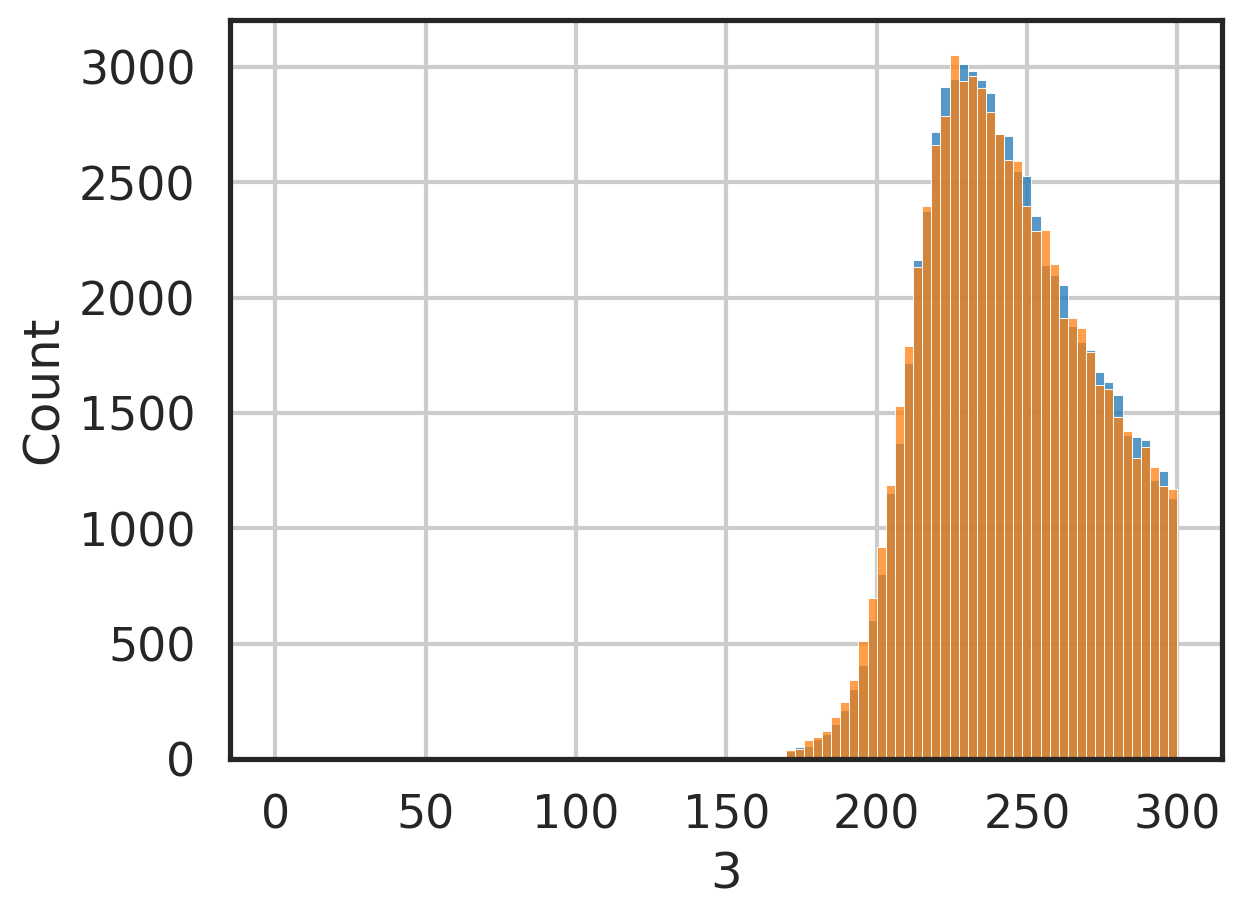

In [8]:
bins = np.linspace(0, 300, 100)
sns.histplot(df1[3], bins=bins)
sns.histplot(df2[3], bins=bins)

In [9]:
# df1sub = df1[df1[3]<200]

In [10]:
th = 0
df1 = df1[df1[3] > th]
print(df1.shape)
df2 = df2[df2[3] > th]
print(df2.shape)

(96677, 4)
(96414, 4)


In [30]:
df1['xbin'] = pd.cut(df1[0], 10, labels=False)
df1['ybin'] = pd.cut(df1[1], 10, labels=False)
df1['zbin'] = pd.cut(df1[2], 20, labels=False)

count1_xy = df1.groupby(['xbin', 'ybin']).size().unstack().T
count1_xz = df1.groupby(['xbin', 'zbin']).size().unstack().T
count1_yz = df1.groupby(['ybin', 'zbin']).size().unstack().T

In [31]:
df2['xbin'] = pd.cut(df2[0], 10, labels=False)
df2['ybin'] = pd.cut(df2[1], 10, labels=False)
df2['zbin'] = pd.cut(df2[2], 20, labels=False)

count2_xy = df2.groupby(['xbin', 'ybin']).size().unstack().T
count2_xz = df2.groupby(['xbin', 'zbin']).size().unstack().T
count2_yz = df2.groupby(['ybin', 'zbin']).size().unstack().T

In [46]:
np.mean(count1_xy)

xbin
0     555.3
1     760.2
2     822.7
3     925.7
4    1049.7
5    1128.0
6    1183.6
7    1163.9
8    1161.6
9     917.0
dtype: float64

Text(0.5, 1.0, 'before/after')

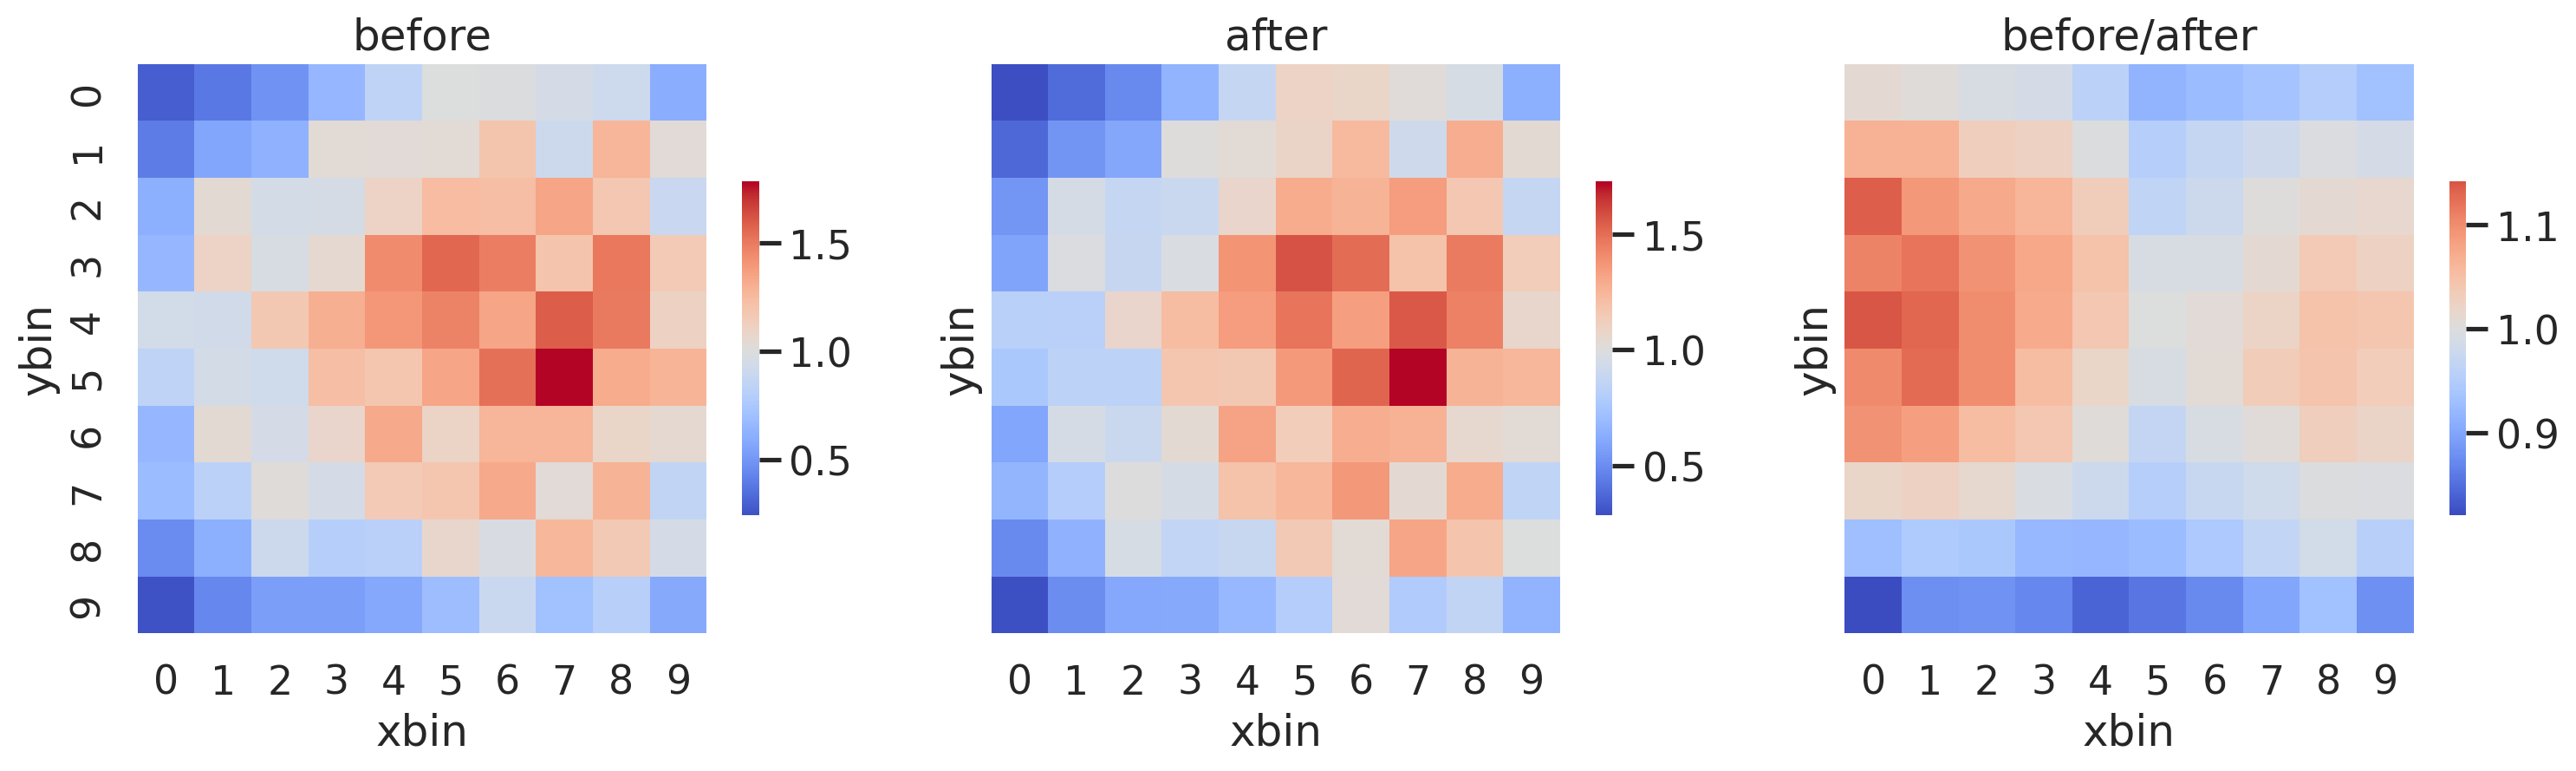

In [49]:
fig, axs = plt.subplots(1,3,figsize=(3*6,5), sharex=True, sharey=True)
ax = axs[0]
sns.heatmap(count1_xy/np.mean(count1_xy.values), ax=ax, cbar_kws=dict(shrink=0.5), cmap='coolwarm', center=1,)
ax.set_aspect('equal')
ax.set_title('before')
ax = axs[1]
sns.heatmap(count2_xy/np.mean(count2_xy.values), ax=ax, cbar_kws=dict(shrink=0.5), cmap='coolwarm', center=1,)
ax.set_aspect('equal')
ax.set_title('after')
ax = axs[2]
sns.heatmap(count1_xy/count2_xy, ax=ax, cbar_kws=dict(shrink=0.5), cmap='coolwarm', center=1,)
ax.set_aspect('equal')
ax.set_title('before/after')

Text(0.5, 1.0, 'before/after')

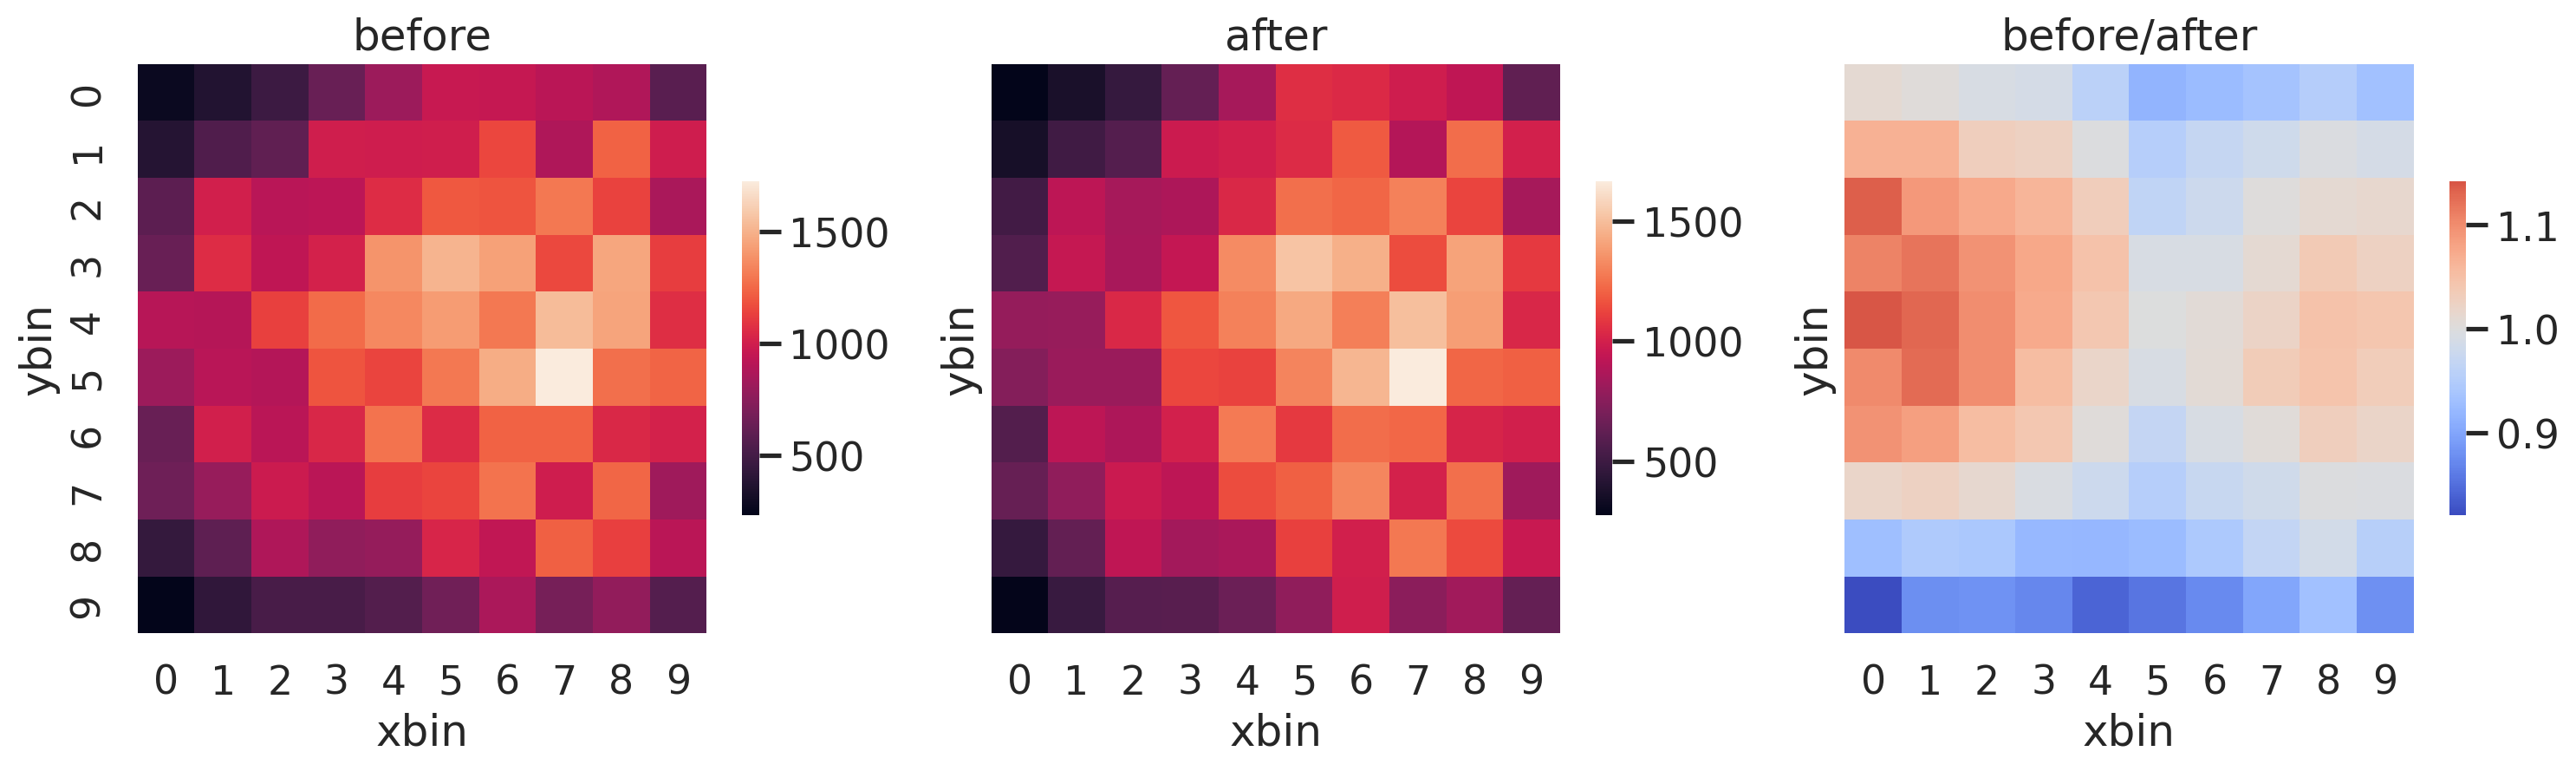

In [28]:
fig, axs = plt.subplots(1,3,figsize=(3*6,5), sharex=True, sharey=True)
ax = axs[0]
sns.heatmap(count1_xy, ax=ax, cbar_kws=dict(shrink=0.5))
ax.set_aspect('equal')
ax.set_title('before')
ax = axs[1]
sns.heatmap(count2_xy, ax=ax, cbar_kws=dict(shrink=0.5))
ax.set_aspect('equal')
ax.set_title('after')
ax = axs[2]
sns.heatmap(count1_xy/count2_xy, cmap='coolwarm', center=1, ax=ax, cbar_kws=dict(shrink=0.5))
ax.set_aspect('equal')
ax.set_title('before/after')

Text(0.5, 1.0, 'before/after')

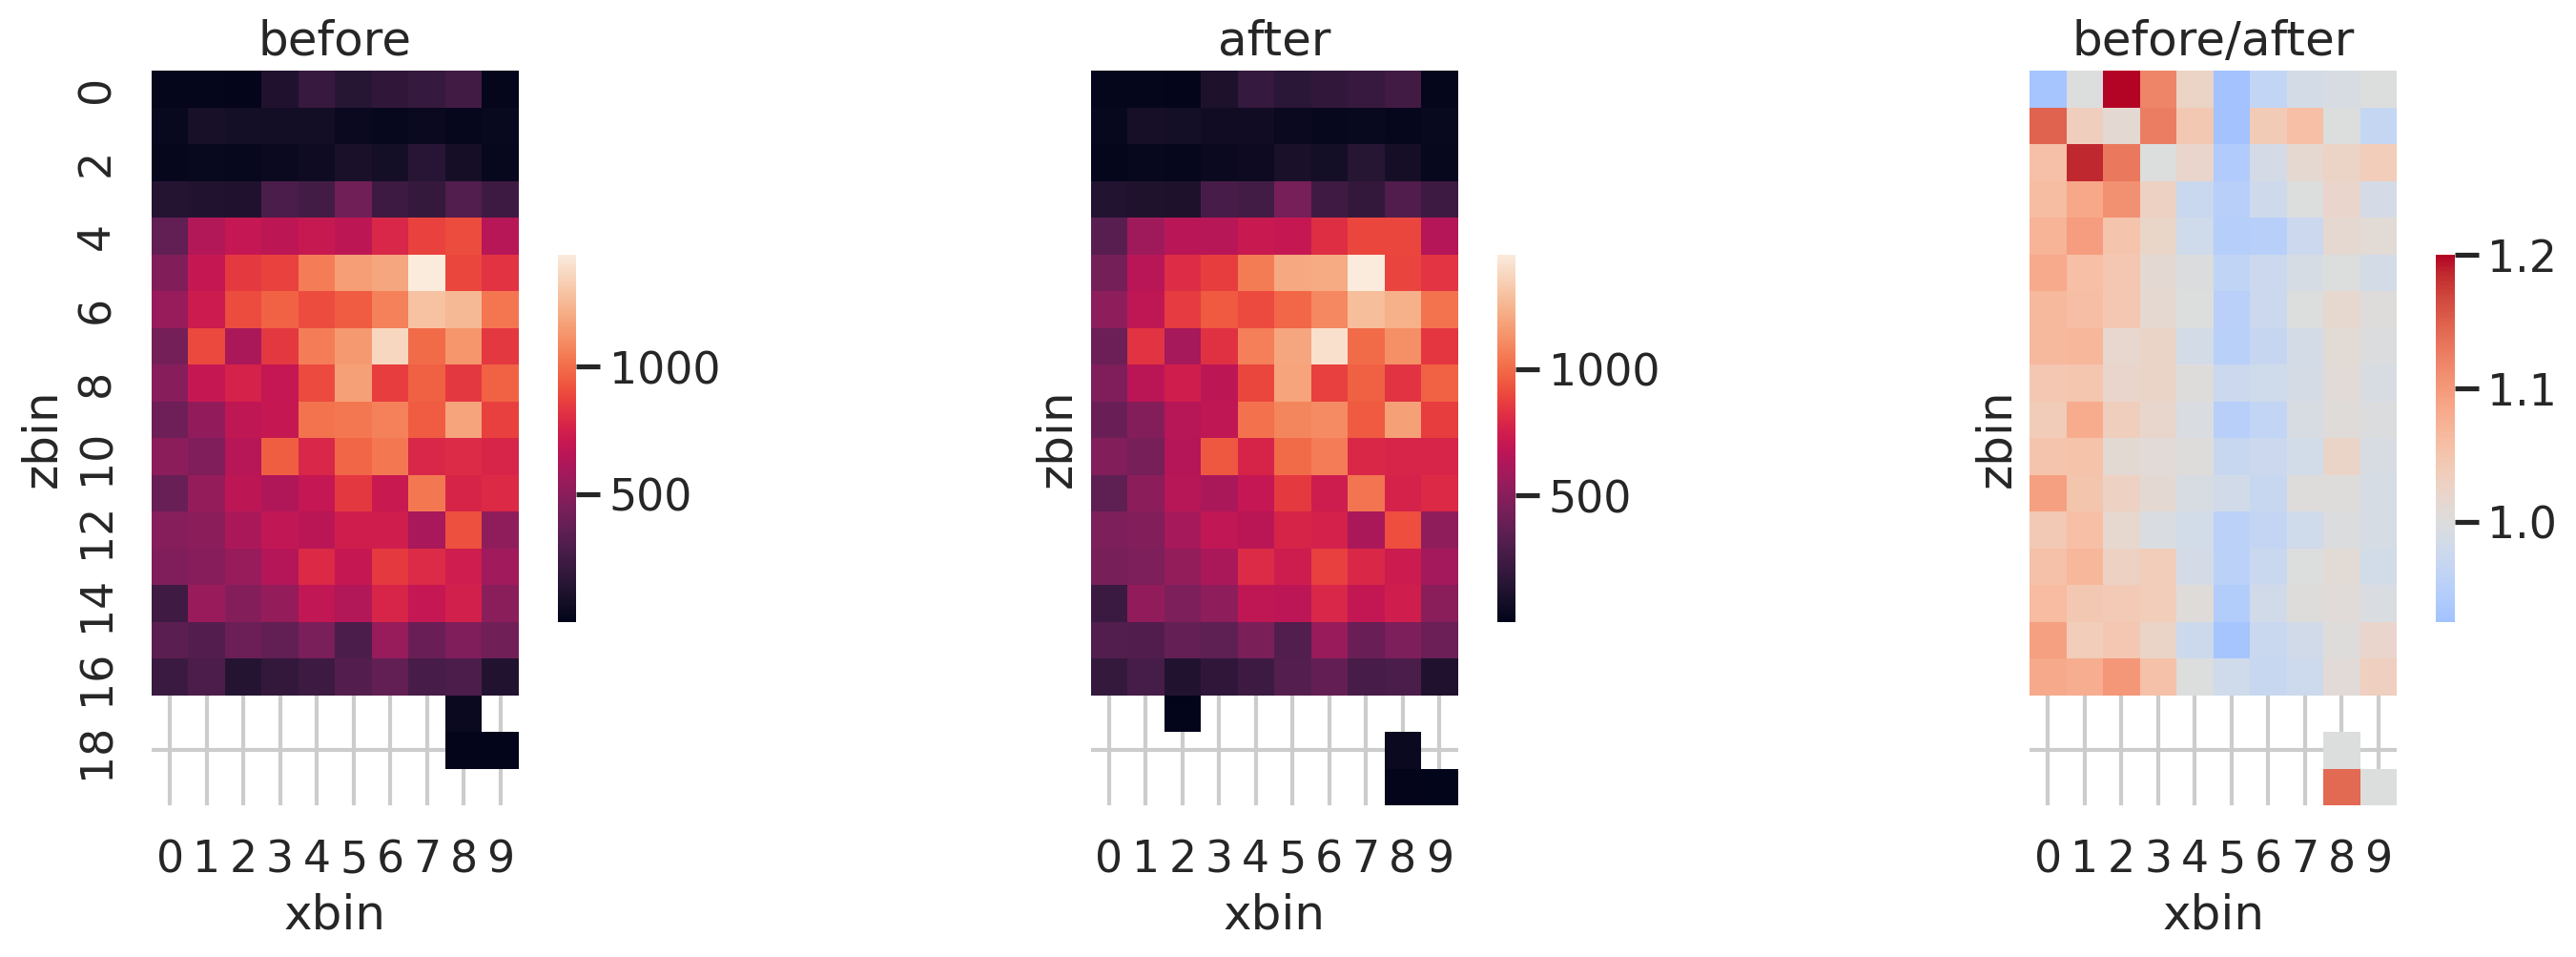

In [36]:
fig, axs = plt.subplots(1,3,figsize=(3*6,5), sharex=True, sharey=True)
ax = axs[0]
sns.heatmap(count1_xz, ax=ax, cbar_kws=dict(shrink=0.5))
ax.set_aspect('equal')
ax.set_title('before')
ax = axs[1]
sns.heatmap(count2_xz, ax=ax, cbar_kws=dict(shrink=0.5))
ax.set_aspect('equal')
ax.set_title('after')
ax = axs[2]
sns.heatmap(count1_xz/count2_xz, cmap='coolwarm', center=1, ax=ax, cbar_kws=dict(shrink=0.5), vmax=1.2)
ax.set_aspect('equal')
ax.set_title('before/after')

Text(0.5, 1.0, 'before/after')

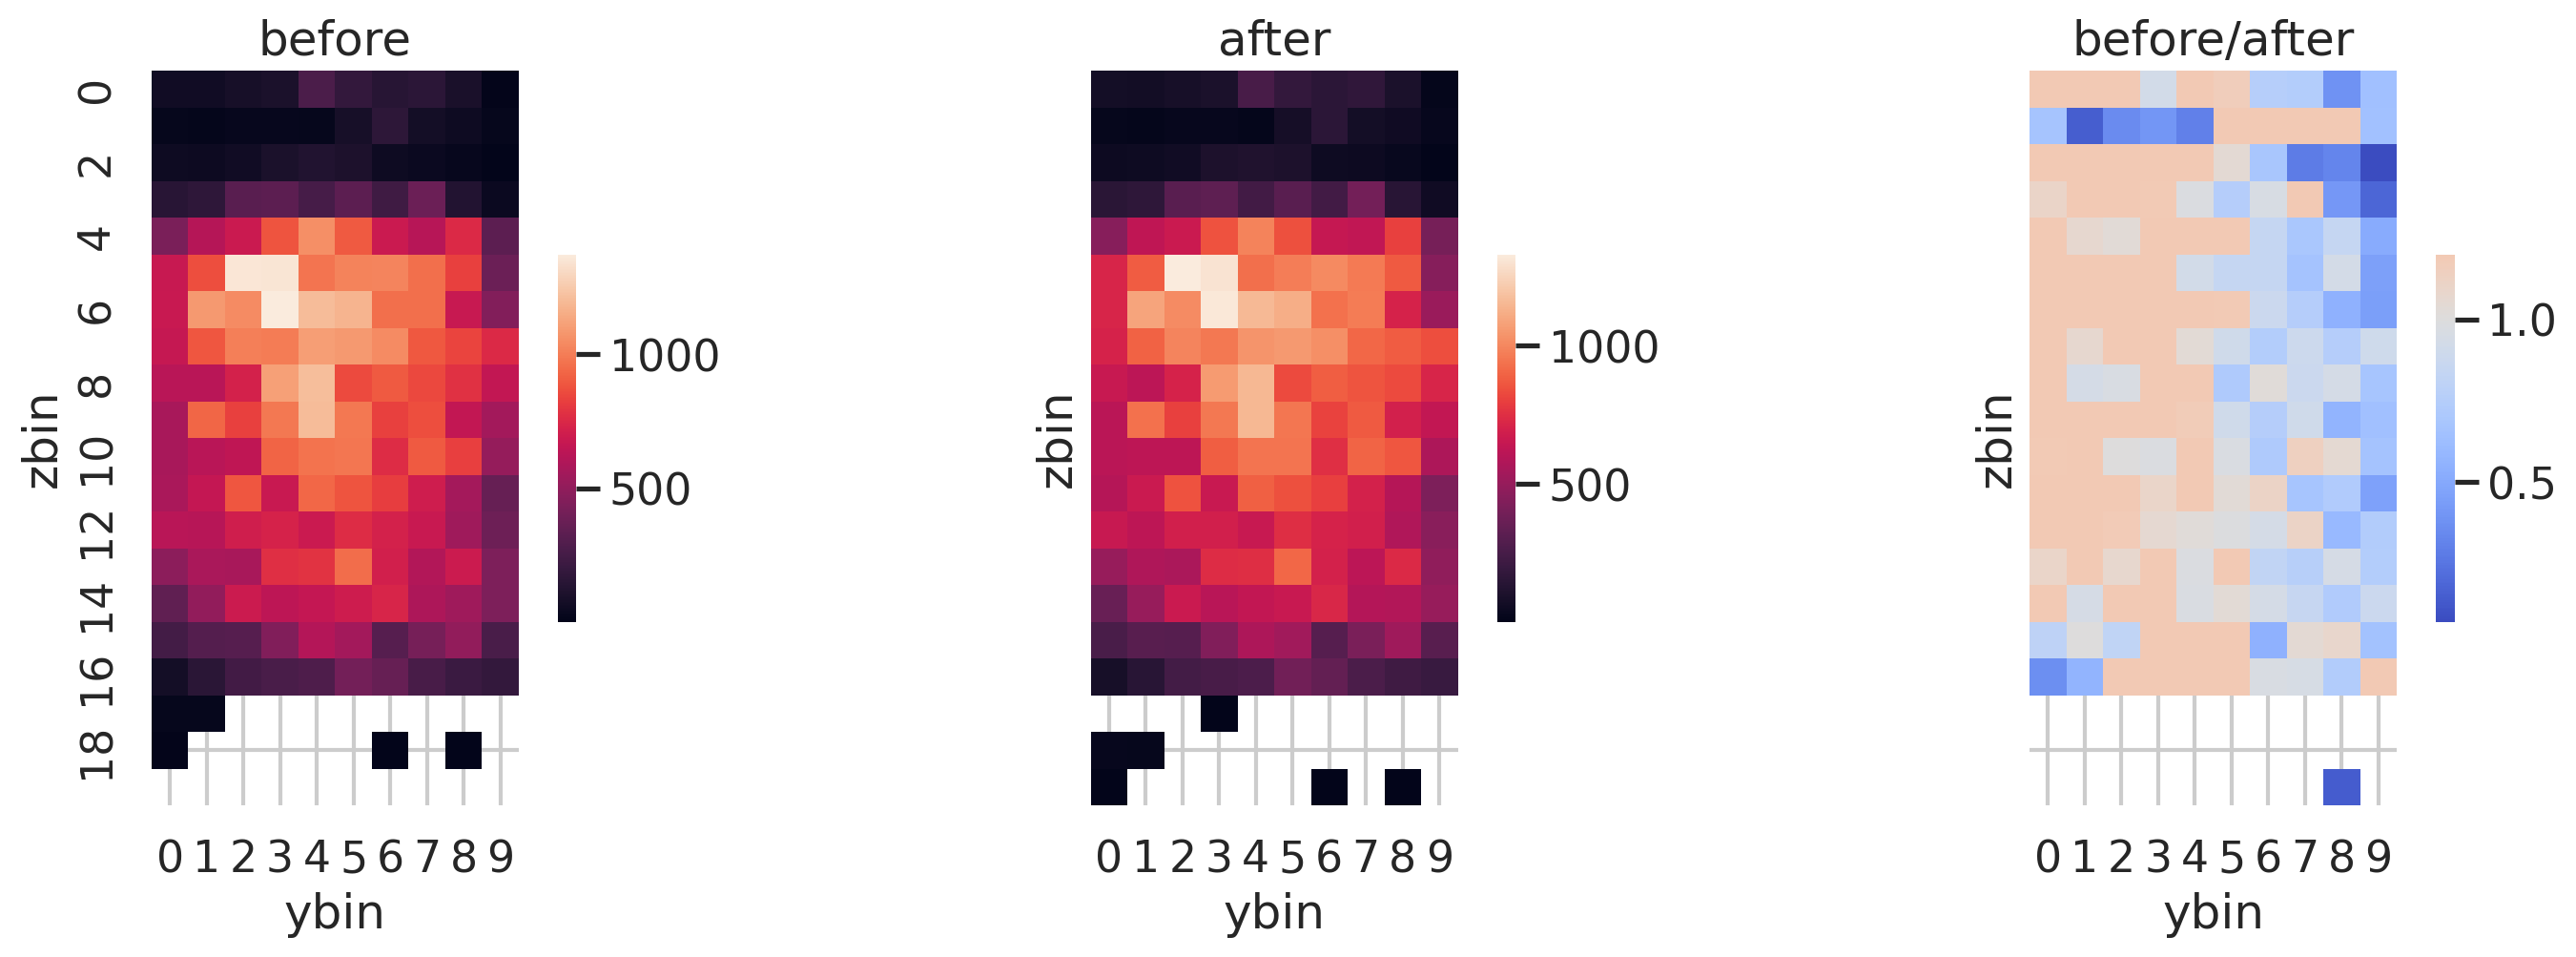

In [37]:
fig, axs = plt.subplots(1,3,figsize=(3*6,5), sharex=True, sharey=True)
ax = axs[0]
sns.heatmap(count1_yz, ax=ax, cbar_kws=dict(shrink=0.5))
ax.set_aspect('equal')
ax.set_title('before')
ax = axs[1]
sns.heatmap(count2_yz, ax=ax, cbar_kws=dict(shrink=0.5))
ax.set_aspect('equal')
ax.set_title('after')
ax = axs[2]
sns.heatmap(count1_yz/count2_xz, cmap='coolwarm', center=1, ax=ax, cbar_kws=dict(shrink=0.5), vmax=1.2)
ax.set_aspect('equal')
ax.set_title('before/after')

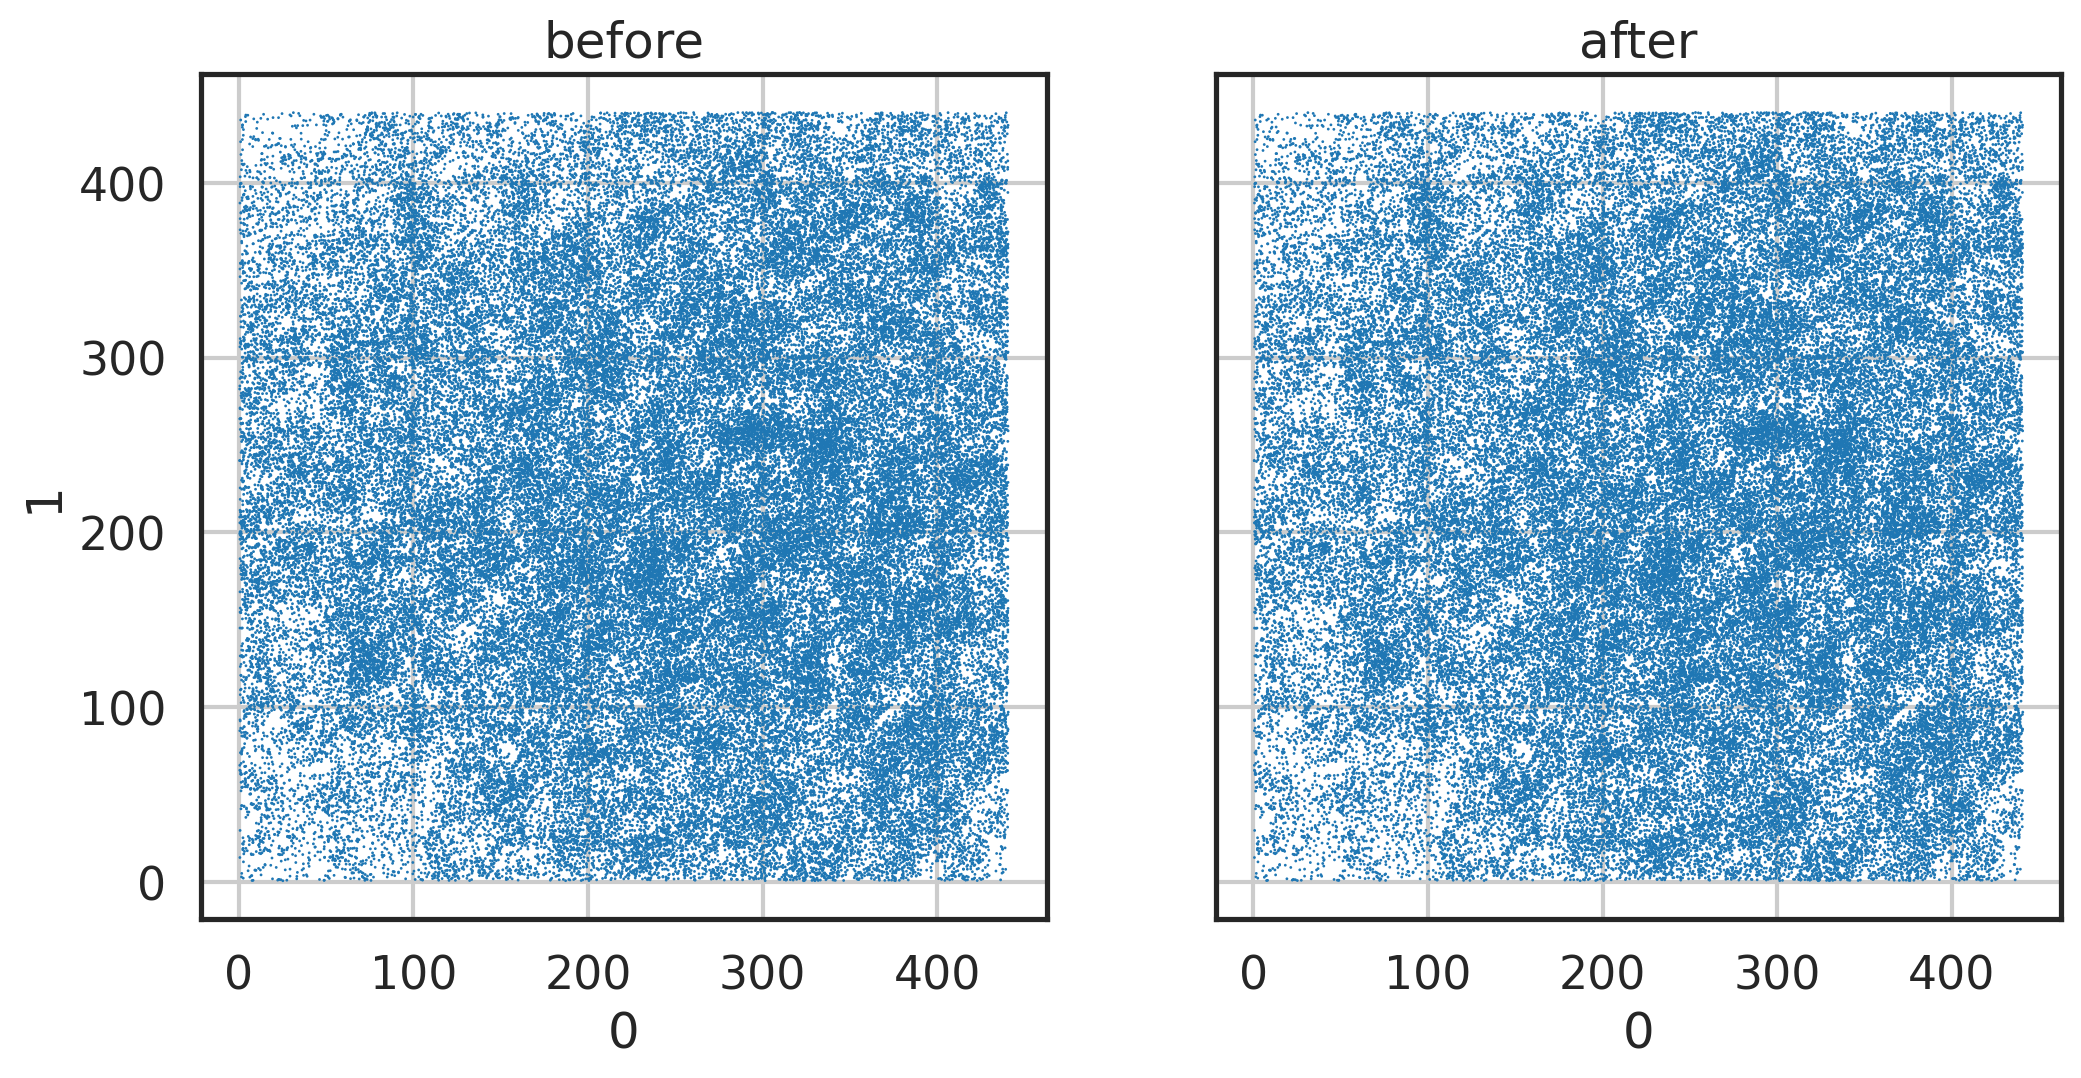

In [43]:
fig, axs = plt.subplots(1,2,figsize=(2*6,3*4), sharex=True, sharey=True)
ax = axs[0]
ax.set_title('before')
sns.scatterplot(data=df1, x=0, y=1, s=1, edgecolor='none', ax=ax)
ax.set_aspect('equal')
ax.invert_yaxis()
ax = axs[1]
ax.set_title('after')
sns.scatterplot(data=df2, x=0, y=1, s=1, edgecolor='none', ax=ax)
ax.set_aspect('equal')
ax.invert_yaxis()
plt.show()

# check raw images

In [16]:
fix = zarr.open(store=zarr.N5Store(fix_dir), mode='r')     
img1 = fix['c0/s1'][...]
img2 = fix['c00/s1'][...]

In [17]:
img1.shape, img2.shape

((400, 960, 960), (400, 960, 960))

In [18]:
import tifffile

outdir = '/u/home/f/f7xiesnm/project-zipursky/easifish/results/viz_sparse06_v2'
!mkdir -p $outdir

print(np.max(img1), np.min(img1))
tifffile.imwrite(outdir+'/c0_s1.tiff', img1)

outdir = '/u/home/f/f7xiesnm/project-zipursky/easifish/results/viz_sparse06_v2'
print(np.max(img2), np.min(img2))
tifffile.imwrite(outdir+'/c00_s1.tiff', img2)

65487 25
2546 90


In [11]:
%%time
# output dir
if not os.path.isdir(output_dir):
    print(output_dir)
    os.mkdir(output_dir)
    
# image size in pixel (x, y, z)
grid = n5mu.read_voxel_grid(fix_dir, subpath)
# voxel resolution in µm (x, y, z) (post-expansion)
vox  = n5mu.read_voxel_spacing(fix_dir, subpath)
# image size in physical space (x, y, z) (post-expansion)
size = grid*vox
print('subpath: ', subpath)
print('voxel size: ', vox)
print('image size (pixel): ', grid)
print('image size (um post-ex): ', size)

# get image data
# print("loading images...")
# fix = zarr.open(store=zarr.N5Store(fix_dir), mode='r')     
# img1 = fix[subpath][:, :, :]

# get segmentation mask
lb = imread(lb_dir)
# roi = np.max(lb) # this is only correct if this lb is uncropped
roi = len(np.unique(lb[lb!=0])) # this would be better
print(lb.shape)
print('num roi: ', roi)

FileNotFoundError: [Errno 2] No such file or directory: '/u/home/f/f7xiesnm/project-zipursky/easifish/sparse06/outputs/r1_flatfield/stitching/export.n5/c3/s3/attributes.json'

In [ ]:
# %%time
# bad_roi = []
# for reg_dir in reg_dirs:
#     reg = zarr.open(store=zarr.N5Store(reg_dir), mode='r')     
#     img2 = reg[subpath][...]
#     print("image loaded")
    
#     # get bad pixels -> bad roi
#     bad_roi_thisround = np.unique(lb[np.nonzero(img2==0)])
#     bad_roi.append(bad_roi_thisround)
#     print("# of ROIs rejected this round:", len(bad_roi_thisround))
    
# bad_roi = np.unique(np.hstack(bad_roi))
# print("# of ROIs rejected:", len(bad_roi))
# bad_roi

In [ ]:
%%time
# # Get list of ROIs that are fully or partially outside the mask 
### Make sure to only include ROIs that are intact and in the overlapping regions across all rounds of FISH
### remove any unregistered parts
if len(reg_dirs) > 0:
    mask = np.ones(grid[::-1])
    for reg_dir in reg_dirs:
        reg = zarr.open(store=zarr.N5Store(reg_dir), mode='r')     
        img2 = reg[subpath][...]
        print("image loaded")
        mask[img2==0]=0
    print("mask generated")

    bad_roi=np.unique(lb[mask==0])
    if bad_roi[0] == 0: # remove the label 0 - extracellular space
        bad_roi = bad_roi[1:]
    np.save(out_badroi, bad_roi)
    print("# of ROIs rejected:", len(bad_roi))

In [ ]:
%%time
# get cell locations (in um - pre-expansion) from segmentation mask
roi_meta_all = roi_prop.roi_prop_v2(lb, lb_res, ex)
roi_meta_all.to_csv(out_allroi)

roi_meta = roi_meta_all.set_index('roi').copy()
roi_meta = roi_meta #.loc[roi_meta.index.difference(bad_roi)]
roi_meta.to_csv(out_roi)

In [ ]:
%%time

# count spots for every cell (roi)

# all labels
lb_id = np.unique(lb[lb!=0]) # exclude 0
lb_id = np.hstack([[0], lb_id]) # include 0 - noncell
# selected cells
lb_id_selected = roi_meta.index.values

# prep
spotcount = pd.DataFrame(index=lb_id_selected, dtype=int)
# spotcount_intn = pd.DataFrame(index=lb_id_selected, dtype=float)

i = 0
for r,chs in round_channels.items():
    for c in chs:
        # f_intns = fx_intns[i]
        f_spots = fx_spots[i]
        intn_th = intn_threshs[i]
        print(r, c, f_spots) #, f_intns)

        # spots
        spots_rc = np.loadtxt(f_spots, delimiter=',')
        print(len(spots_rc))

        # filter
        filter_cond = spots_rc[:,3] > intn_th
        spots_rc = spots_rc[filter_cond]
        print(len(spots_rc))

        # count spots
        res = spot.spot_counts_worker(lb, spots_rc, lb_res,
                                      lb_id=lb_id, 
                                      remove_noncell=True, 
                                      selected_roi_list=lb_id_selected,
                                      )
        spotcount[f"{r}_{c}"] = res 

        # # count spots by intensity
        # res = spot.get_spot_counts_from_intn(f_intns, f_spots, roi_meta, lb_res)
        # spotcount_intn[f'{r}_{c}'] = res
        i = i + 1
    
# save results
spotcount.to_csv(out_spots)
# spotcount_intn.to_csv(out_spots_intn)

In [ ]:
# # reconcile two spot counts
# dist_cutoff = 2 # um pre-expansion
# density = spotcount.divide(roi_meta['area'], axis=0)
# cond = density < 1/(dist_cutoff**3) # keep spots if density is low

# print("# cells have high density: ", (~cond).sum()) 
# spotcount_merged = spotcount.where(cond, spotcount_intn)  # replace where the condition is False
# spotcount_merged.to_csv(out_spots_merged)
# spotcount_merged

In [ ]:
spotcount